# A Stock Trading Strategy based on ELM

In this Project we are implementing a trading strategy which uses Extreme Machine Learning and Oscillation Box Theory to predict stock price.


## Packages Needed
We start by importing all the needed modules for our project 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

## Simple Parameters  
Explanation: We are bascially using n2 days of stock price data as input for our ELM and the closing price of the next n1 days as an output of our ELM. N3 is number of nodes in the hidden layer in our SLFN. 
Here we are also loading our data form the csv file named AAPL.csv

In [3]:
# defining Variables Values
n1 = 15
n2 = 60    
n3 = 780

# Reading Data into our system
data = pd.read_csv("AAPL.csv")
data.head()
close_high = max(data['Close'])
close_low = min(data['Close'])

## Gray Correlation Degree
We are using Gray Correlation Degree to calculate the weights as input for our ELM. GCD use the following formula:

$ r(t_i, x_i) = \frac{min|t_i - x_i| + \xi max|t_i - x_i|}{|t_i - x_i| + \xi max|t_i - x_i|} $

In [4]:
# Gray Correlation Degree (GCD)

def GCD(t_arr, x_arr, xi=0.5): # xi should be between (0,1)
    
    t_x_arr = np.absolute(np.subtract(t_arr, x_arr))
    
    r_arr = (min(t_x_arr) + xi*max(t_x_arr))/(t_x_arr + xi*max(t_x_arr))
    
    return r_arr
    

## Moving Average
We are using 30 day Moving Average as one of the input for our ELM 

In [5]:
# Moving Average
def MA(a, n=30):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret[n - 1:] = ret[n - 1:] / n
    ret[:n-1] = 0
    return ret

## Rate of change
Formula

$ ROC price = \frac{cur_{price} - prev_{price}}{prev_{price}} $

In [6]:
# ROC rate of change 
def ROC(a, n=30):
    
    re = ((a[n:] - a[:len(a)-n])/a[:len(a)-n])*100
    re = np.concatenate((np.zeros(n),np.array(re)))
    return re
    

## Relative Strength Index
Formula:

$ RSI_{step one} = 100 - \left[ \frac{100}{1 + \frac{Average Gain}{Average Loss}} \right] $

In [7]:
# RSI Relative strength index

def singleRSI(a):
    
    # daily gain or loss
    
    ret = (a[1:] - a[:len(a)-1])/a[:len(a)-1]
    zero = np.zeros(len(a)-1)
    ind = ret > zero
    avg_gain = np.mean(ret[ind])
    avg_loss = np.mean(-ret[np.logical_not(ind)])
    return 100 - (100/(1 + (avg_gain/avg_loss)))

def RSI(a, n=30):

    re = np.zeros(len(a)-n)
    for i in range(len(a)-n):
        re[i] = singleRSI(a[i:n+i])
    
    return np.concatenate((np.zeros(n),re))

## Stochastics 
FastK, SlowK and SlowD are different stochastics which are trying to measure the sensitivity of the stock price.

FastK Formula:

$ FastK = \frac{100 * (CP - L14)}{(H14 - L14} $

CP = Closing Price

L14 = Lowest Price of the previous 14 days

H14 = Highest Price of the previous 14 days

In [8]:
# FastK 
def FastK(a, k=14):
    
    re = np.zeros(len(a)-k)
    for i in range(len(a)-k):
        re[i] = 100*(a[i] - min(a[i:k+i]))/(max(a[i:k+i]) - min(a[i:k+i]))
    
    return np.concatenate((np.full([k], 0),re))

SlowK = Moving Average of 3 prev FastKs

In [9]:
# SlowK
def SlowK(a, k=3):
    
    return MA(FastK(a),k)
    
    

SlowD = Moving Average of 3 prev SlowKs

In [10]:
# SlowD
def SlowD(a, k=3):
    
    return MA(SlowK(a),k)

In [11]:
# Upk's and Lowk's
def Upk(a, n1 = 15):
    
    re = np.zeros(len(a)-n1)
    for i in range(len(a)-n1):
        re [i] = max(a[i:n1+i])
    
    return np.concatenate((np.full([n1], 0),re))

def Lowk(a, n1 = 15):
    
    re = np.zeros(len(a)-n1)
    for i in range(len(a)-n1):
        re [i] = min(a[i:n1+i])
    
    return np.concatenate((np.full([n1], 0),re))

## Normalization
We are Pre-processing History Indictors. Basically passing alll our input features through a normalization technique. We are normalizing all indictor between [-1,1] 

In [12]:
# Normalize Function between (-1,1)

def Norm(a):
    
    return (-1 + 2*((a - min(a))/(max(a)-min(a))))

def Norm_df(df):
    
    for i in df.columns:
        
        if i != 'Date':
            df[i] = Norm(np.array(df[i]))
    
    return df

## Putting all features together
In this step we add all the calculated features to our data

In [13]:
# populating calculated values

# MA
data['MA'] = MA(np.array(data['Close']))

# ROC 
data['ROC'] = ROC(np.array(data['Close']))

# RSI
data['RSI'] = RSI(np.array(data['Close']))

# FastK
data['FastK'] = FastK(np.array(data['Close']))

#SlowK
data['SlowK'] = SlowK(np.array(data['Close']))

#SlowD
data['SlowD'] = SlowD(np.array(data['Close']))

#UpK
data['Upk'] = Upk(np.array(data['Close']))

#Lowk
data['Lowk'] = Lowk(np.array(data['Close']))

data = Norm_df(data)


## Closing Price
Looking at the closing price closely we can see that the stock of AAPL has risen significantly since 2006

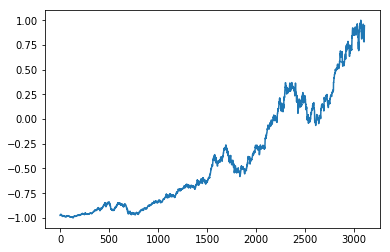

In [14]:
plt.plot(data['Close'])

## Movementum 
The Stock Price Movementum can be calculated using ROC and RSI

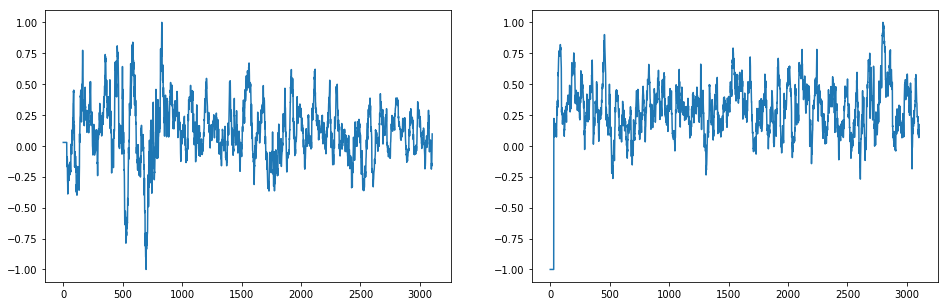

In [15]:
fig, (axs1, axs2) = plt.subplots(1,2, figsize=(16,5))
axs1.plot(data['ROC'])
axs2.plot(data['RSI'])


## Stochastics 
Stochastics are used to measure the sensitivities of the stock price. We are using 3 Stochastics. The slower the stochastic the less sensitive it is to change. So the curve of SlowK is smoother than FastK and similarly the curve of SlowD is smoother than SlowK.  

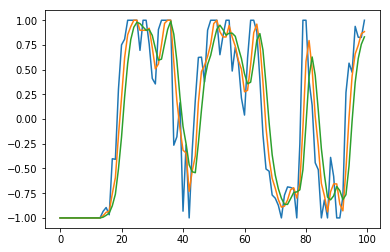

In [16]:
plt.plot(data['FastK'][:100])
plt.plot(data['SlowK'][:100])
plt.plot(data['SlowD'][:100])

## Processing data for the ELM model
We are using 13 daily features and a n2 day window as our input vector giving us a total of $ 13*n_2 $ input nodes and $ n_1$ output nodes.

### GCD 
Since we are calcualting GCD between two features with different sample sizes (example: 15, 60) we need to expand one feature to fit the larger one. so we expand the smaller feature by filling the intermediate values linearly. and then we calculate the final weighted feature vector.

Formula:

$ F_i = [O_k, H_k, L_k, C_k, Vol_k, MA_k, ROC_k, RSI_k, FastK_k, SlowK_k, SlowD_k, UpK_k, LowK_k] $

where $ k = (i-1,i-2, ... ,i-n2) $

$ I_i = F_i ^{\circ} W_i $

In [17]:
# Recreating Paper
# ELM 
# creating data for training
Feature = np.zeros(( len(data)-n2-30-n1, 13*n2))

for i in range(len(data)-n2-30-n1):
    
    Feature[i] = data[30+i:30+i+n2].drop(['Date'],axis=1).values.flatten()

Target = np.zeros((len(data)-n2-30-n1, n1))

for i in range(len(data)-n2-30-n1):
    
    Target[i] = data['Close'][30+i+n2:30+i+n2+n1]

# Gray Correaltion Degree
def expand_arr(arr,s1,s2):
    
    div = (s2-s1)//(s1-1)
    ext = (s2-s1)%(s1-1)
    new_arr = np.zeros(s2)
    j = 0
    for i in range(s1-1):
        
        if ext > 0:
            adder = (arr[i+1] - arr[i])/(div+1)
            new_arr[j] = arr[i]
            j += 1
            for k in range(div+1):
                new_arr[j] = arr[i] + adder
                adder += adder
                j += 1
            ext -= 1
            
        else:
            adder = (arr[i+1] - arr[i])/(div)
            new_arr[j] = arr[i]
            j += 1
            for k in range(div):
                new_arr[j] = arr[i] + adder
                adder += adder
                j += 1
    new_arr[j] = arr[i+1]
    
    return new_arr

# getting GCD for all the values of the feature vector
'''
Since our feature vector has 60 variables and target 
has 15 we need to expand the array from 15 to 60 to get 1:1 gcd correlation
'''
new_Target = np.zeros((len(data)-n2-30-n1, n2))

for i in range(len(data)-n2-30-n1):
    
    new_Target[i] = expand_arr(Target[i],n1,n2)

GCD_weights = np.zeros(( len(data)-n2-30-n1, 13*n2))
for i in range(len(data)-n2-30-n1):
    
    for j in range(13):
        GCD_weights[i][j*n2:(j+1)*n2] = GCD( new_Target[i], Feature[i][j*n2:(j+1)*n2])

Feature = np.multiply( Feature, GCD_weights) 

In [18]:
# Sigmoid Function

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## ELM Training
ELM theory suggests that the weights and baises of the hidden layer are selected at random and the weights of the output layer are calculated using simple optimization. Here we have generated the weights and baises using Uniform distribution. The weights of the output layer $ \beta_i $ are calculated by taking the Moore Penrose generalized inverse of the output of the hidden layer and then multiplying it with the actual output.

$ \beta = G^{\dagger} \cdot T$

for calculating the Moore Penrose generalized inverse matrix we used Singular-Value Decomposition technique

In [42]:

weights = np.random.randn(13*n2,n3)
bais = np.random.randn( n3)
F_train, F_test, T_train, T_test = train_test_split(Feature,Target,test_size=0.1,random_state=42)
beta = np.zeros((len(F_train),n3,n1))
baises = [bais]*len(F_train)
beta = np.linalg.pinv(np.matrix(sigmoid((F_train @ weights)+baises))) @ T_train




## Testing
We are testing the ELM model. we have partitioned the data into 90:10 Train and test data set and after train the data we use the ELM model to predict the result and we calculate the prediction error Mean Squared Error.

In [43]:
baises = [bais]*len(F_test)

mean_squared_error(sigmoid((F_test @ weights)+baises) @ beta, T_test)

0.0026754831408512723

## Simulating the actual trading strategy 
The real test of our algorithm is not actual price prediction but the basically the profit we would get from applying our strategy. Here we simulate a very basci strategy where if the closing price is close to the low end of the oscillation box and we don't any have stocks then we buy the maximum possible stock with out current amount and if the closing price is high and we have stocks then we sell all the stocks. Here when starting with an initial portfolio of 100 dollars we end up with a substancial profit at the end. 

In [44]:
# Trading strategy

next_trade = "buy"
buy_price = 0
sell_price = 0

sigma = 0.015
phi = 0

fie = 0.05
theta = 0.05

initial_amount = 100
amount = 100
no_stocks = 0

for i in range(len(data)-n2-30-n1):
    
    ci = Feature[i][13*(n2-1) + 3]
    pred = sigmoid((Feature[i] @ weights)+bais) @ beta
    lowi = pred.min()
    upi = pred.max()
    
    if next_trade == "buy":
        
        if abs(ci - lowi)/ci <= sigma:
            if sell_price - ci >= phi:
                buy_price = ci
                no_stocks = amount/((ci + 1)*(close_high - close_low)/2 + close_low)
                amount = 0
                next_trade = "sell"
    
    elif abs(ci - upi)/ci <= sigma:
        
        if ci - buy_price >= fie:
            sell_price = ci
            amount = no_stocks*((ci + 1)*(close_high - close_low)/2 + close_low)
            no_stocks = 0
            next_trade = "buy"

amount

1790.5612838689651

## Improvement (suggested)
We can clearly see that we are using high dimensional data as input and along with that our input feature are also derived from just one feature(Closing price). So it is reasonable to think that the input data might be highly correlated and so we applying a simple linear dimensionality reduction technique called Principle Component Analysis to lower number of the input features and then perform the same test on our data.

In [46]:
pca = PCA(n_components=300)
pca.fit(Feature)

pca_Feature = pca.fit_transform(Feature)

In [48]:
# setting the weights random
# the hidden layer will have 13*n2*n weights and n baises

weights = np.random.randn(300,n3)
bais = np.random.randn( n3)
F_train, F_test, T_train, T_test = train_test_split(pca_Feature,Target,test_size=0.1,random_state=42)
beta = np.zeros((len(F_train),n3,n1))
baises = [bais]*len(F_train)
beta = np.linalg.pinv(np.matrix(sigmoid((F_train @ weights)+baises))) @ T_train

baises = [bais]*len(F_test)

mse = mean_squared_error(sigmoid((F_test @ weights)+baises) @ beta, T_test)

print("Mean Squared Error "+str(mse))
# Trading strategy

next_trade = "buy"
buy_price = 0
sell_price = 0

sigma = 0.015
phi = 0

fie = 0.05
theta = 0.05

initial_amount = 100
amount = 100
no_stocks = 0

for i in range(len(data)-n2-30-n1):
    
    ci = Feature[i][13*(n2-1) + 3]
    pred = sigmoid((pca_Feature[i] @ weights)+baises) @ beta
    lowi = pred.min()
    upi = pred.max()
    
    if next_trade == "buy":
        
        if abs(ci - lowi)/ci <= sigma:
            if sell_price - ci >= phi:
                buy_price = ci
                no_stocks = amount/((ci + 1)*(close_high - close_low)/2 + close_low)
                amount = 0
                next_trade = "sell"
    
    elif abs(ci - upi)/ci <= sigma:
        
        if ci - buy_price >= fie:
            sell_price = ci
            amount = no_stocks*((ci + 1)*(close_high - close_low)/2 + close_low)
            no_stocks = 0
            next_trade = "buy"
        
    

print("We have started with an amount of "+str(initial_amount))
print("The final amount we get after trading is "+str(amount))

Mean Squared Error 0.007153062128812905
We have started with an amount of 100
The final amount we get after trading is 1790.5612838689651


## Observations

### General Strategy
We proposed a new approach of a more dynamic stock decision support system which has proved to be more lucrative. In our experiment we started with an initial portfolio of 100 dollars and on an average ended up with 1800 dollars. Which translates to a very significant 24% annual rate for our 12 years of trading.

### Error
We used Mean Squared error as a our error determination metric. We get a consistent value of 0.0025 MSE for our Normal Feature and 0.007 for our PCA generated features. 

### Splitting training and testing
We also noticed a key thing which is that when the training and test data is split unshuffled or as a time series then we get a much higher MSE for both our features. This migth because of the fact that Apple's stock price has since quite a few highs and low since 2000's owing to the fact that they made quite a few major changes to their business model and also because of the outstanding success of the Iphone.

### Random weight generation
We also tried using Normally distributed random values for weights and baises, which lead to a higher MSE but we can't precisely point out why this happens exactly.   

### Improvements
We have improved on the provided strategy by applying PCA on the input features to reduce the number of input features from 780 to 300. This significant decrease in input features gives the same Profit for our trading strategy although it does give us a slightly higher MSE, but all things considered PCA has definitely improved the efficiency of our algorithm which is very important as we want to make decisions in real time.

## Conclusion
In our experiment,
we have shown that our system is capable of superior performance to give investors
considerable returns, especially when the stock price in a fluctuant movement the system can
bring more lucrative benefits. Which can be attributed to two factors. The first one is the
fast learning ability and high precision of ELM and coupled that with PCA which makes it even faster. The second one is that trading with box theory is based on only on the highest and lowest values the stock could reach in a certain period
of time, which reduces the impact of noise and uncertainty in the stock market on
the prediction accuracy. Lastly, using Gray Correlation degree (GCD) method to obtain each
factor weight helps the ELM get more precise results.